<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Overview of Pyleoclim: Efficient & Flexible Timeseries Analysis

## Authors

Deborah Khider1, Julien Emile-Geay2, Alexander James2, Feng Zhu3

1 Information Sciences Institute, University of Southern California 2 Department of Earth Sciences, University of Southern California 3 Nanjing University of Information Science and Technology

Author1 = {"name": "Deborah Khider", "affiliation": "Information Sciences Institute, University of Southern California", "email": "khider@usc.edu", "orcid": "0000-0001-7501-8430"}
Author2 = {"name": "Julien Emile-Geay", "affiliation": "Department of Earth Sciences, University of Southern California", "email": "julieneg@usc.edu", "orcid": "0000-0001-5920-4751"}
Author3 = {"name": "Alexander James", "affiliation": "Department of Earth Sciences, University of Southern California", "email": "akjames@usc.edu", "orcid": "0000-0001-8561-3188"}
Author4 = {"name": "Feng Zhu", "affiliation": "Nanjing University of Information Science and Technology", "email": "fzhu@nuist.edu", "orcid": "0000-0002-9969-2953"}

## Preamble

### Goals:

* Get acquainted with the Pyleoclim package, namely the objects and their associated methods
* Learn to create a Series object from a csv file
* Call the default methods for plotting, spectral and wavelet analysis
* Construct workflows with Pyleoclim


**Reading Time:**

10 minutes

### Keywords

Visualization; Signal Processing; Spectral Analysis; Wavelet Analysis; Method Cascading

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: http://linked.earth/ec_workshops_py/.

### Relevant Packages

Pandas; Matplotlib

## Data Description

Sea-surface temperature from [Kaplan (1998)](https://psl.noaa.gov/data/gridded/data.kaplan_sst.html) averaged over the NINO3 (5N-5S, 150W-190E)) region.


## Demonstration

Let's import the packages needed for this tutorial:

In [1]:
import pyleoclim as pyleo
import pandas as pd

### Step 1: Create a `Series` object from a csv file

To do so, we will first read the data from a csv file and load into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html):

In [2]:
df = pd.read_csv('../data/wtc_test_data_nino_even.csv')
df.head()

,t,air,nino
0,1871.000000,87.36090,-0.358250
1,1871.083333,-21.83460,-0.292458
2,1871.166667,-5.52632,-0.143583
3,1871.250000,75.73680,-0.149625
4,1871.333333,105.82000,-0.274250


Next we create a `Series` object from the columns of the `DataFrame`:

In [3]:
ts_nino = pyleo.Series(time =  df['t'], value = df['nino'], label = 'Kaplan Niño3 SST',
                  time_name = 'Year', value_name = 'NINO3 index',
                  time_unit = 'CE',   value_unit = '$^{\circ}$C')            

Time axis values sorted in ascending order


Let's make a simple plot. You can learn to customize this plot in the `publication_ready_figures.ipynb` tutorial:

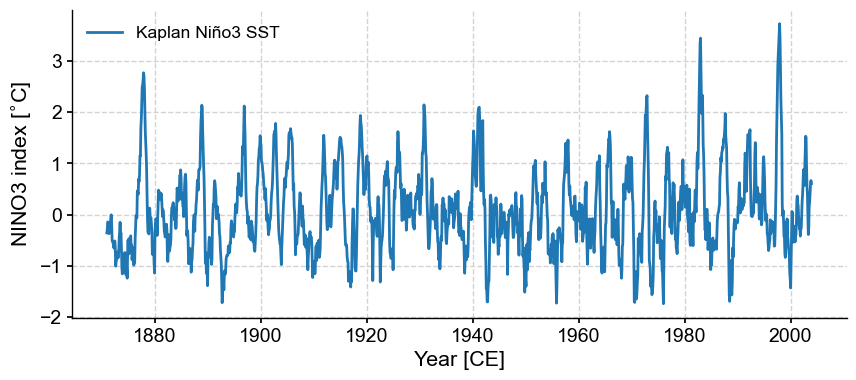

In [4]:
fig, ax = ts_nino.plot()

You can also make a warming stripe for this `Series`:

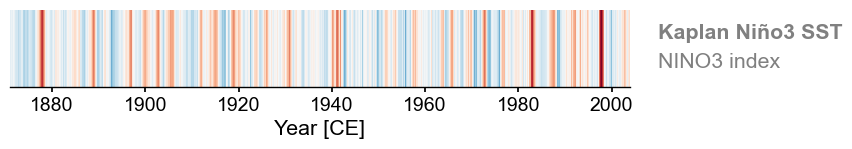

In [5]:
fig, ax = ts_nino.stripes(ref_period=(1961,1990), show_xaxis=True)

### Step 2: Pre-processing

Pyleoclim has multiple functionalities to pre-process a timeseries, including standardizing, detrending, interpolation. You can learn about the various pre-processing steps in the [basic Series manipulations](L0_basic_ts_manipulation.md), [filtering and detrending](L1_filtering_and_detrending.md),  and [uniform time sampling](L1_uniform_time_sampling.md) tutorials. As an example of one treatment, let's standardize the data and plot it against the original values. 

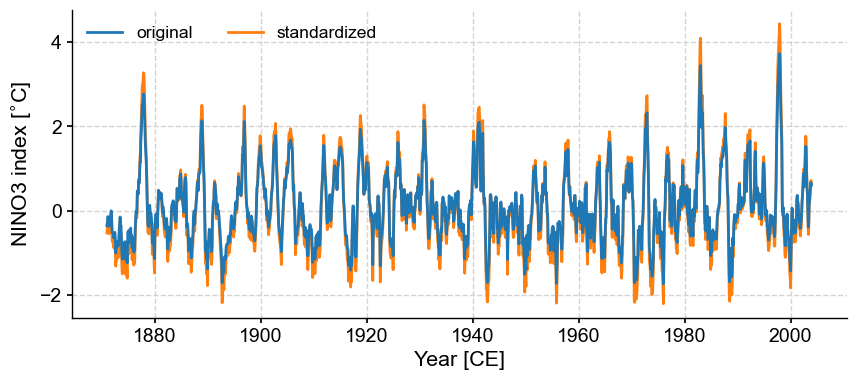

In [6]:
ts_nino_std = ts_nino.standardize()

fig, ax = ts_nino.plot(label='original', zorder=99) # a high zorder ensures this is plotted on top
ax = ts_nino_std.plot(label='standardized', ax=ax, lgd_kwargs={'ncol': 2})

For more on graphics customizations,  see [figures with multiple panels](L1_figures_with_multiple_panels.ipynb). 

### Step 3: Spectral Analysis

Pyleoclim makes it simple to perform spectral analysis. Calling the `.spectral()` method will yield a `PSD` (power spectral density) object of the corresponding series. Unless specified otherwise, `.spectral()` uses the Lomb-Scargle periodogram (`method='lomb_scargle`), which can handle both evenly-spaced data and unevenly-spaced data with great speed. However, it has known biases,  so it may be appropriate to specify an alternative method, like the Multi-Taper Method, which can only handle evenly-spaced data.  For our example data, both methods apply.

In [6]:
psd_wwz = ts_nino_std.spectral()  # method='lomb-scargle' by default 
psd_mtm = ts_nino_std.spectral(method='mtm')  # method='mtm' 

We can then plot the results of our analyses on the same figure:

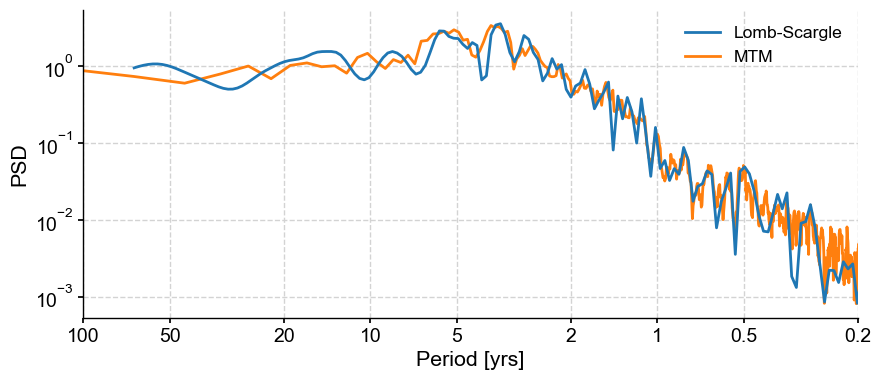

In [7]:
fig, ax = psd_wwz.plot(label='Lomb-Scargle',zorder=99)
ax = psd_mtm.plot(ax=ax, label='MTM')

To identify notable periodicities, we need to perform some significance test.
Currently, *Pyleoclim* supports the test against an AR(1) benchmark, which can be performed by simply calling the `signif_test()` method, which uses 200 surrogate series by default:

In [8]:
psd_mtm_signif = ts_nino_std.spectral(method='mtm').signif_test()

Performing spectral analysis on individual series: 100%|█████████| 200/200 [00:15<00:00, 12.95it/s]


Calling the `plot()` method on our `psd_mtm_signif` object will return a plot of the PSD along with the AR(1) threshold curve, which we can use to identify the significant cycles.

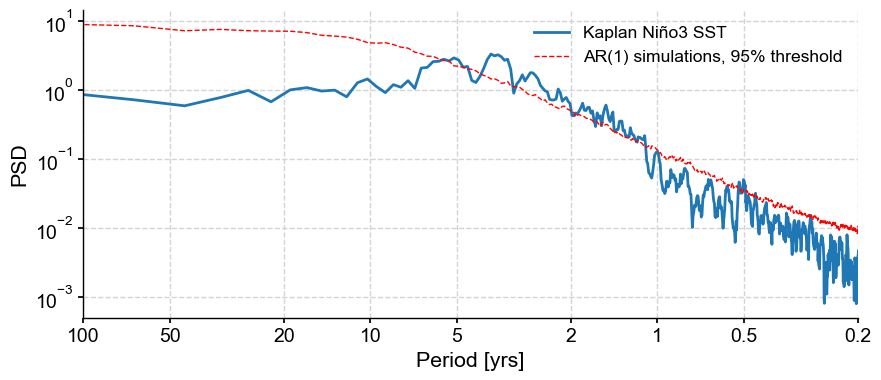

In [9]:
fig, ax = psd_mtm_signif.plot()

For more details, see the [spectral analysis](L2_spectral_analysis.md) notebook.

### Step 4: Wavelet Analysis

The current version of *Pyleoclim* supports the `wwz` method for wavelet analysis on unevenly-spaced records and the `cwt` method for evenly-spaced records. `wwz` is more flexible than `cwt` in the sense that it can be used on any record, but is much slower (no free lunch!). To perform wavelet analysis we simply call the `wavelet()` method, which will in turn create a `Scalogram` object. Since our data is evenly spaced, we'll use `cwt`, which is the default:

In [10]:
scal = ts_nino_std.wavelet() 

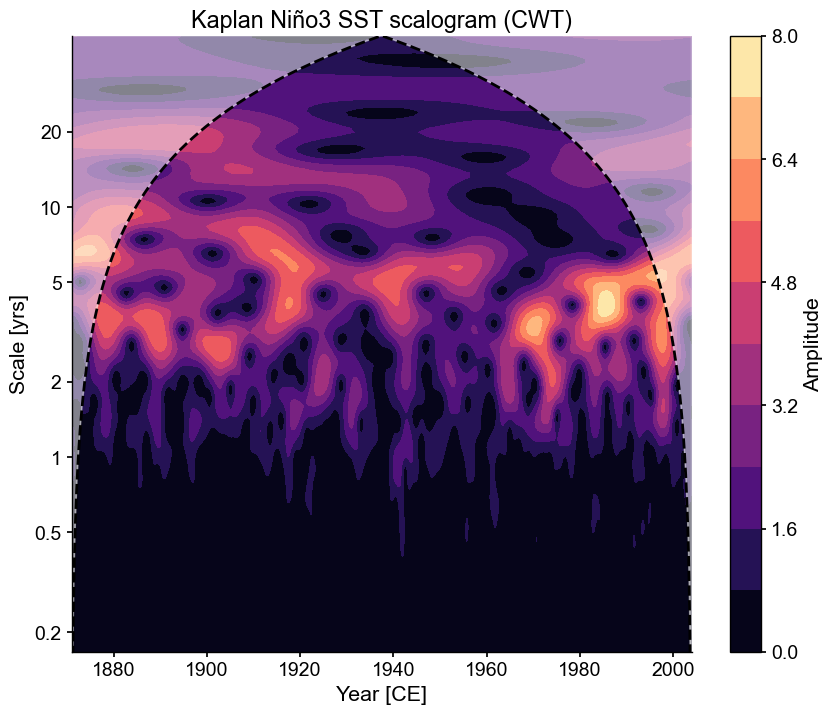

In [11]:
fig, ax = scal.plot() 

Notice how the title got built automatically from the figure metadata.  We can also perform significance analysis the same way we did when conducting spectral analysis:

In [12]:
scal_signif = ts_nino_std.wavelet().signif_test()

Performing wavelet analysis on individual series: 100%|██████████| 200/200 [00:04<00:00, 48.08it/s]


In this case, regions of significance (those that exceed the 95% confidence threshold found using AR1 surrogates) will be outlined in white.

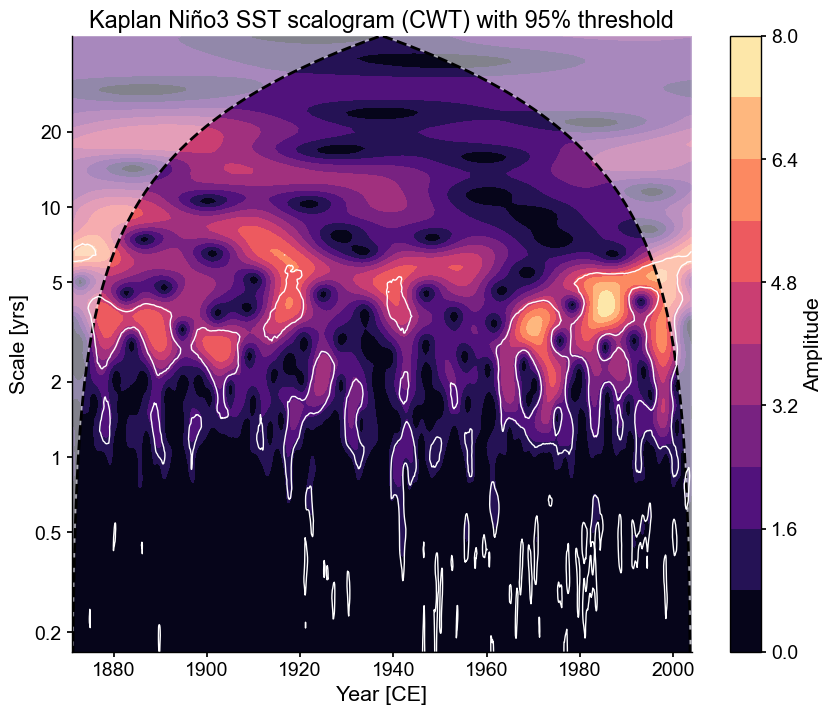

In [13]:
fig, ax = scal_signif.plot()

For more details, see the *L2_wavelet_analysis.ipynb* notebook.

### One more thing: method cascading

Life is short. `Pyleoclim` provides a very cool feature to make life a little bit easier: "method cascading". This feature allows us to string together the steps of a multi-step workflow in just one line.

Performing spectral analysis on individual series: 100%|█████████| 200/200 [00:15<00:00, 12.58it/s]


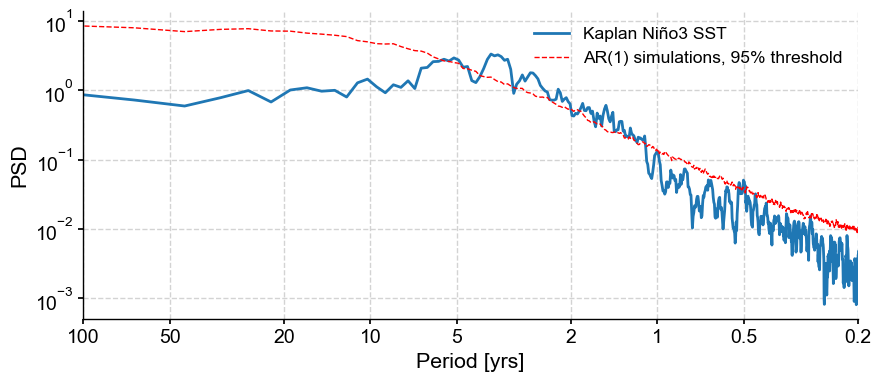

In [14]:
#Spectral analysis with a significance test
fig, ax = ts_nino.standardize().spectral(method='mtm').signif_test().plot()

Performing wavelet analysis on individual series: 100%|██████████| 200/200 [00:04<00:00, 46.67it/s]


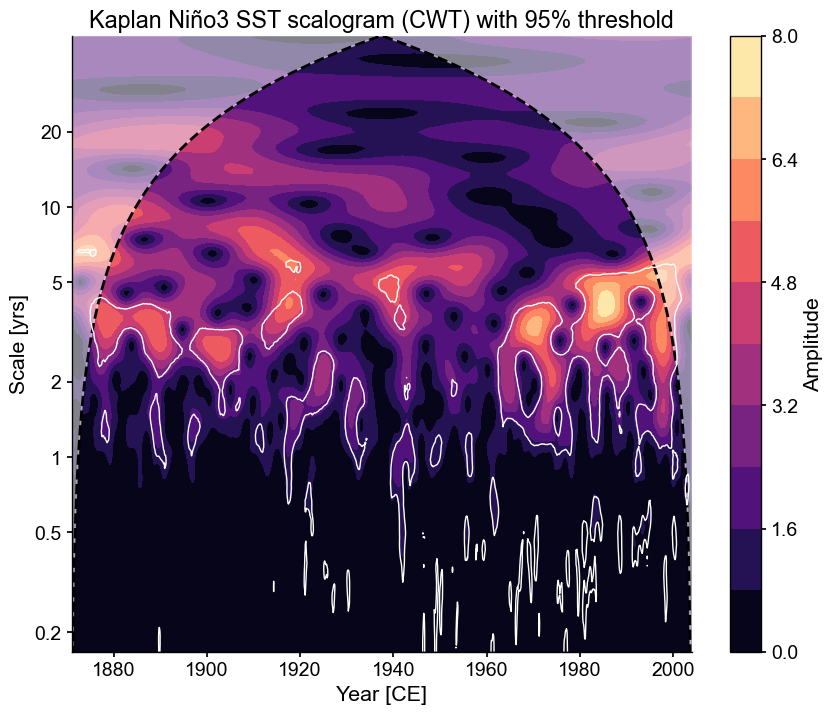

In [15]:
#Wavelet analysis with significance test
fig, ax = ts_nino.standardize().wavelet().signif_test().plot()

If you think some of this could serve your goals, try the other notebooks in this repository.